In [1]:
import sys
sys.path.append('..')
import numpy as np
import matplotlib.pyplot as plt
from hardwares.hardware_params import hardware_params
from model_analyzer import ModelAnalyzer

/home/shen/miniconda3/envs/3dsim/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# model_id="meta-llama/Llama-2-13b-hf"
model_id="Qwen/Qwen2.5-7B"
hardware="Samsung_Exynos_2400"
analyzer=ModelAnalyzer(model_id,hardware)

use config file configs/Qwen.py for Qwen/Qwen2.5-7B


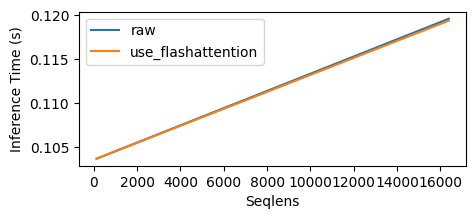

In [3]:
fig=plt.figure(figsize=(5, 2))
for use_flashattention in [False,True]:
    # batchsizes=range(1,64)
    # ys=[]
    # for batchsize in batchsizes:
    #     result=analyzer.analyze(1024,batchsize,16,16,16,use_flashattention)
    #     ys.append(result["total_results"]["decode"]["inference_time"])
    # plt.plot(batchsizes,ys,label=f"use_flashattention" if use_flashattention else "raw")
    seqlens=[128,256,512,1024,2048,4096,8192,16384]
    ys=[]
    for seqlen in seqlens:
        result=analyzer.analyze(seqlen,1,8,8,8,use_flashattention)
        ys.append(result["total_results"]["decode"]["inference_time"])
    plt.plot(seqlens,ys,label=f"use_flashattention" if use_flashattention else "raw")
plt.legend()
plt.ylabel("Inference Time (s)")
plt.xlabel("Seqlens")
plt.savefig("../output/quantization_memory_access_seqlens.pdf",bbox_inches='tight')

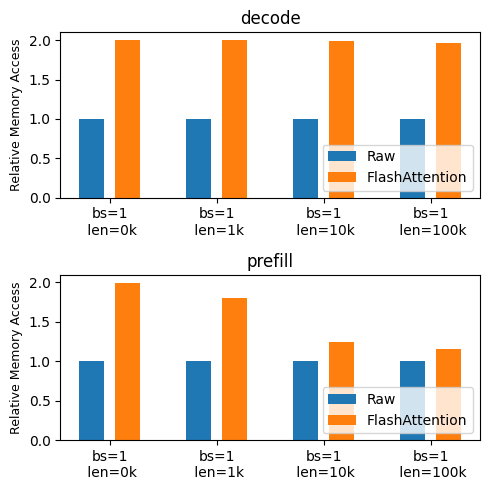

In [4]:
fig=plt.figure(figsize=(5, 5))
bar_width = 0.7

for step in ['decode','prefill']:
    plt.subplot(2, 1, 1 if step=='decode' else 2)
    kvs=[]
    tmp_acts=[]
    categories=[]
    annotation_xs=[]
    annotation_texts=[]
    xs=[]
    xs_use=[]
    x_st=0
    values=[]
    use_values=[]
    # for batchsize,seqlen in [(1,1000),(1,10000),(1,100000),(16,1000),(64,1000)]:
    for batchsize,seqlen in [(1,100),(1,1000),(1,10000),(1,100000)]:
        raw_value=0
        annotation_xs.append(x_st+0.5)
        annotation_texts.append(f"bs={batchsize}\n len={seqlen//1000}k")
        # result=analyzer.analyze(seqlen,batchsize,16,16,16,use_flashattention=False)
        result=analyzer.analyze(seqlen,batchsize,8,8,8,use_flashattention=False)
        values.append(1)
        xs.append(x_st)
        x_st+=1
        result_use=analyzer.analyze(seqlen,batchsize,16,16,16,use_flashattention=True)
        use_values.append(result_use["total_results"][step]["memory_access"]/result["total_results"][step]["memory_access"])
        xs_use.append(x_st)
        x_st+=2
    plt.bar(xs, values, bar_width, label='Raw')
    plt.bar(xs_use, use_values, bar_width, label='FlashAttention')
    plt.ylabel('Relative Memory Access', fontsize=9)

    plt.xticks(annotation_xs,annotation_texts)
    plt.title(step)
    plt.legend(loc="lower right")
    plt.tight_layout()

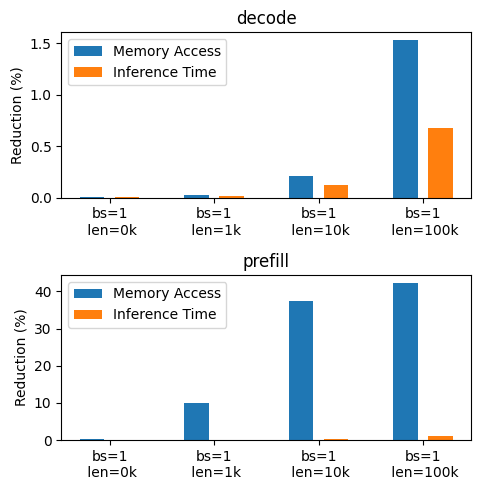

In [5]:
fig=plt.figure(figsize=(5, 5))
bar_width = 0.7

for step in ['decode','prefill']:
    plt.subplot(2, 1, 1 if step=='decode' else 2)
    kvs=[]
    tmp_acts=[]
    categories=[]
    annotation_xs=[]
    annotation_texts=[]
    xs=[]
    xs2=[]
    x_st=0
    time_reductions=[]
    memory_access_reductions=[]
    # for batchsize,seqlen in [(1,1000),(1,10000),(1,100000),(16,1000),(64,1000)]:
    for batchsize,seqlen in [(1,100),(1,1000),(1,10000),(1,100000)]:
        raw_value=0
        annotation_xs.append(x_st+0.5)
        annotation_texts.append(f"bs={batchsize}\n len={seqlen//1000}k")
        # result=analyzer.analyze(seqlen,batchsize,16,16,16,use_flashattention=False)
        # result_use=analyzer.analyze(seqlen,batchsize,16,16,16,use_flashattention=True)
        result=analyzer.analyze(seqlen,batchsize,8,8,8,use_flashattention=False)
        result_use=analyzer.analyze(seqlen,batchsize,8,8,8,use_flashattention=True)
        memory_access_reductions.append(1-result_use["total_results"][step]["memory_access"]/result["total_results"][step]["memory_access"])
        xs.append(x_st)
        x_st+=1
        time_reductions.append(1-result_use["total_results"][step]["inference_time"]/result["total_results"][step]["inference_time"])
        xs2.append(x_st)
        x_st+=2
    plt.bar(xs, [_*100 for _ in memory_access_reductions], bar_width, label='Memory Access')
    plt.bar(xs_use, [_*100 for _ in time_reductions], bar_width, label='Inference Time')
    plt.ylabel('Reduction (%)')

    plt.xticks(annotation_xs,annotation_texts)
    plt.title(step)
    plt.legend()
    plt.tight_layout()
plt.savefig("../output/flashattention_reduction.pdf",bbox_inches='tight')